## Objective:
Create relationship between the combined dataset that has lon and lat data and segments and/or water bodies. 

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString
from pyproj import Proj


## Steps:
- Clean the data
- Convert lon and lot to Points
- Find the closest segment and water body to each study point
- Export the results as CSv for Neo4j

In [11]:
# pt_df = pd.read_csv('data/import/ACA.csv')
pt_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Unnamed: 0                           498 non-null    int64   
 1   CrossingId                           498 non-null    object  
 2   Group                                498 non-null    object  
 3   Number                               498 non-null    object  
 4   StructureType                        498 non-null    object  
 5   CrossingName                         498 non-null    object  
 6   Date                                 498 non-null    object  
 7   RoadName                             498 non-null    object  
 8   Latitude                             498 non-null    float64 
 9   Longitude                            498 non-null    float64 
 10  Fish Spp                             491 non-null    object  
 11  Barriers up

In [33]:
pt_df['Longitude'] = pt_df['Longitude'].apply(lambda x: -1 * x if x > 0 else x)

In [43]:
pt_df = pt_df[pt_df['Longitude'] != 0]

In [44]:
pt_df['Longitude'] = pt_df['Longitude'].apply(lambda x: x/100000 if x < -100 else x)

/home/javad/anaconda3/envs/NHN/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [45]:
min(pt_df['Longitude']) , max(pt_df['Longitude'])

(-58.79265, -52.40941667)

In [46]:
# create points
pt_df = gpd.GeoDataFrame(
    pt_df, geometry=gpd.points_from_xy(pt_df.Longitude, pt_df.Latitude), crs="EPSG:4326")# crs of waterbodies is 4326

<AxesSubplot:>

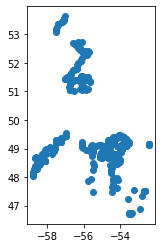

In [48]:
pt_df.plot()

## Points location and segments relationship
Find the closest segment to each point

<AxesSubplot:>

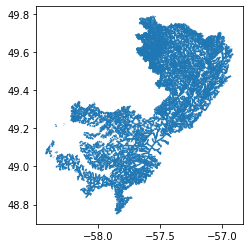

In [49]:
fl_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HN_NLFLOW_1.shp')
fl_df.plot()

# Flatten the geo data:
Data from open Canada is 3d, i.e. has a Z component. convert to 2d:

<AxesSubplot:>

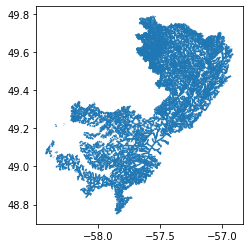

In [50]:

def ddd_to_dd_line(g):
    return LineString([xy[0:2] for xy in list(g.coords)]) 

fl_df['geometry'] = fl_df.geometry.apply(lambda x: ddd_to_dd_line(x))
fl_df.plot() 


In [51]:

def ckdnearesl_line(gdfA, gdfB, gdfB_cols=[], utm_zone = 21):
    """ A is point and B is Linestring
        returns the closest line of gdfB to each point of gdfA and their distance in meters
    """
    gdfA = gdfA.reset_index(drop=True).copy()
    gdfB = gdfB.reset_index(drop=True).copy()
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist-meters')], axis=1)
    return gdf


## Creating segment ID
As the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [52]:
fl_df['row_index'] = fl_df.index
fl_df['row_index'] = fl_df['row_index'].astype('str')
fl_df['segment_id'] = fl_df['DATASETNAM'] + "-" + fl_df.row_index

# Finding the closest segment to each point:

The data is geographic and has lon and lat. To get the distances in meter, we need to project it onto a map. Use this site to find the UTM zone and pass that to the next function. https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#

In [53]:
# columns to keep from segment dataframe:
fl_cols = ['segment_id'] 

UTM_ZONE = 21 # most of Newfoundland is in this zone 

pt_fl_nearept_df = ckdnearesl_line(pt_df, fl_df, fl_cols, utm_zone= UTM_ZONE )

<ipython-input-51-dc5d58cbd102>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


### Sort by distance:

In [54]:
pt_fl_nearept_df.sort_values('dist-meters')


,Unnamed: 0,CrossingId,Group,Number,StructureType,CrossingName,Date,RoadName,Latitude,Longitude,...,DFO Comments,Obstruction?,Sent_to_Reg_Review,Monitoring & Occurences Unit Update,Added to pick list?,Issue,Action Required,geometry,segment_id,dist-meters
209,210,Humber Arm28,Humber Arm,28,Barrier,South Brook 004,2019-09-24,North Harbour Road,48.978290,-57.608830,...,NaN,No,NaN,NaN,NO,NaN,NaN,POINT (-57.60883 48.97829),02YL000-25466,1.377265
205,206,Humber Arm24,Humber Arm,24,Culvert,Blue Gulch Brook 004,2019-09-24,"Main Street, Pasadena",49.017370,-57.593820,...,NaN,No,NaN,NaN,NO,NaN,NaN,POINT (-57.59382 49.01737),02YL000-27434,2.487667
198,199,Humber Arm17,Humber Arm,17,Culvert,East Branch (Rocky Brook) 004,2019-09-20,Tamarack Rd,49.292520,-57.422940,...,NaN,No,NaN,NaN,NO,NaN,NaN,POINT (-57.42294 49.29252),02YL000-25633,3.003832
200,201,Humber Arm19,Humber Arm,19,Culvert,West Rocky Brook 001,2019-09-20,Route 430,49.248410,-57.467890,...,"3.7% Slope, high flow visible in culvert.",Yes,2020-07-13,NaN,NO,NaN,NaN,POINT (-57.46789 49.24841),02YL000-27255,3.935123
219,220,Humber Arm38,Humber Arm,38,Culvert,Wigwam Brook 003,2019-10-11,Riverside Road,49.452166,-56.975983,...,1% slope and culvert is showing signs of failure.,Maybe,NaN,NaN,NO,NaN,NaN,POINT (-56.97598 49.45217),02YL000-26444,5.724857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,423,NCC12,NCC,12,Culvert,CJ-C8 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.496789,-57.068778,...,Backwatered but beaver debris inside could be ...,Maybe,NaN,NaN,YES,Water too deep to fully assess,Further assessment required (try a safer appro...,POINT (-57.06878 53.49679),02YL000-38,413920.082891
423,424,NCC13,NCC,13,Culvert,CJ-C9 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.512111,-57.072083,...,BACKWATERED,No,NaN,NaN,NO,NaN,NaN,POINT (-57.07208 53.51211),02YL000-38,415601.206589
424,425,NCC14,NCC,14,Culvert,CJ-C10 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.532694,-57.067056,...,"0.91% slope, and low water levels. Culvert cou...",Maybe,NaN,NaN,NO,NaN,NaN,POINT (-57.06706 53.53269),02YL000-38,417910.628924
425,426,NCC15,NCC,15,Culvert,CJ-C11 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.560667,-57.060139,...,Debris at inlet could be a barrier,Maybe,NaN,NaN,NO,NaN,NaN,POINT (-57.06014 53.56067),02YL000-38,421049.621403


Points are matched with the closest segments to them. Segments are identified by segment_id. The distances between the points locations and the closest segments are stored in the `dist` column.

<AxesSubplot:>

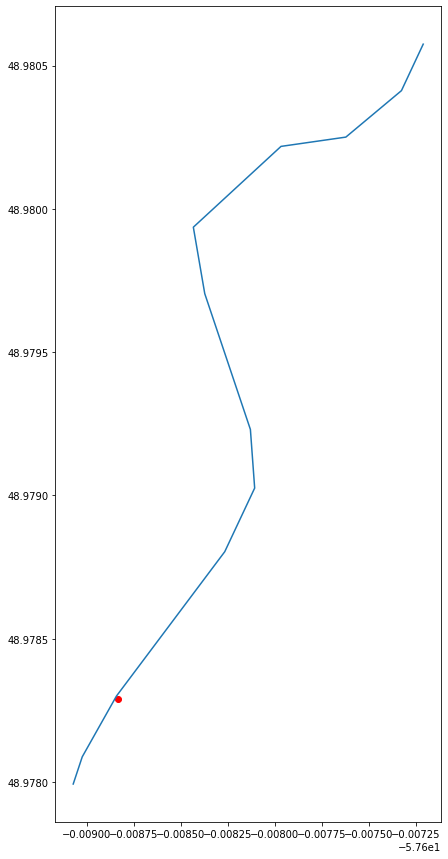

In [58]:
# plot one point and its closest segment

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df[fl_df['segment_id'] == '02YL000-25466'].plot(ax=ax)
pt_fl_nearept_df[pt_fl_nearept_df['CrossingId'] =='Humber Arm28'].plot(color='red', ax= ax)


## plot points and segments:

<AxesSubplot:>

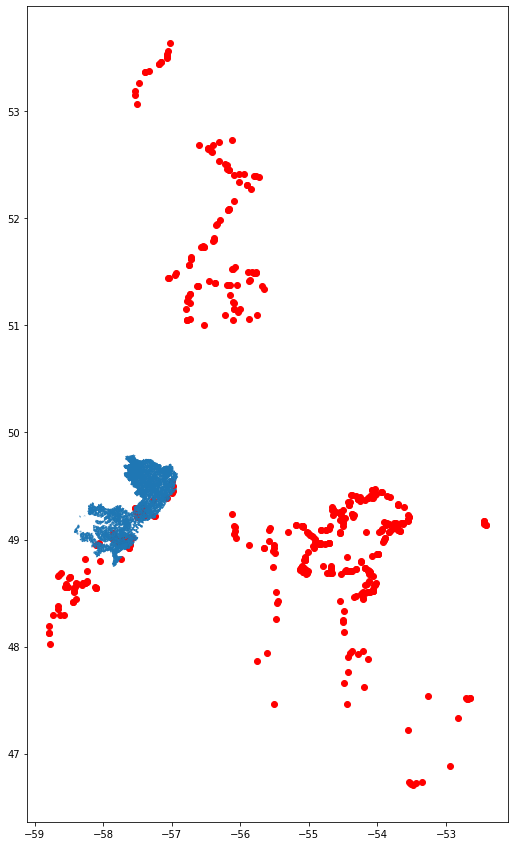

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df.plot(ax=ax)
pt_fl_nearept_df.plot(color='red', ax= ax)


# Segments are not covering:
As the plot shows, there are many points that are outside of the region covered by the segment file.
- Solution:
    - Filter out distant points
    - Import more segment data (For other regions)
     
     
### Segments and points that have a distance less than 200 meters:

(47, 39)

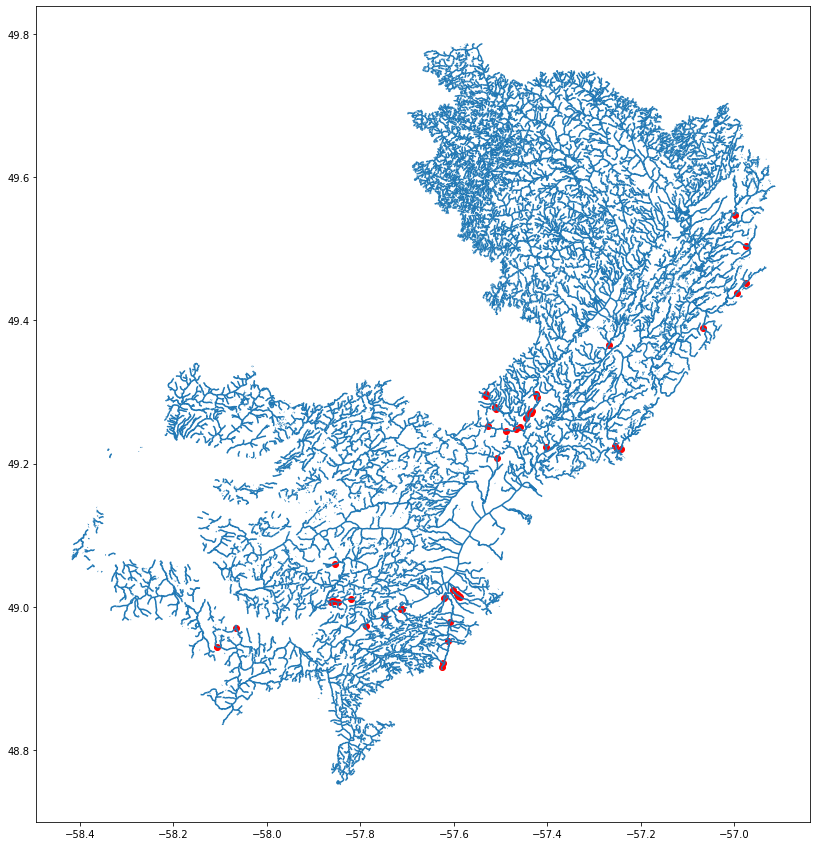

In [60]:
# plot points withing the segment region

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df.plot(ax=ax)
# pt_fl_nearept_df.iloc[0:5,:].plot(color='red', ax= ax)
pt_fl_nearept_df[pt_fl_nearept_df['dist-meters'] < 200].plot(color='red', ax= ax)
# fl_df.plot()
pt_fl_nearept_df[pt_fl_nearept_df['dist-meters'] < 200].shape

## Save :
- CSV for database import


In [28]:
pt_fl_nearept_df['lat'] = pt_fl_nearept_df['Latitude']
pt_fl_nearept_df['lon'] = pt_fl_nearept_df['Longitude']
pt_fl_nearept_df.drop(['Latitude', 'Longitude', 'LATITUDE', 'LONGITUDE'], axis=1).to_csv('y_points_to_segments.csv', index=False)
# pt_fl_nearept_df

In [61]:
pt_fl_nearept_df.to_csv('data/ACA_to_segments.csv', index=False)

## Study to water body connection:
Repeat the same process for water bodies dataset.

In [62]:
wb_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HD_WATERBODY_2.shp')

In [63]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKEID_2,RIVID_1,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09..."
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73..."
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53..."
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54..."
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21..."


## Creating water body ID
Similar to segments, as the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [64]:
wb_df['row_index'] = wb_df.index
wb_df['row_index'] = wb_df['row_index'].astype('str')
wb_df['waterbody_id'] = wb_df['DATASETNAM'] + "-" + wb_df.row_index

In [65]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry,row_index,waterbody_id
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09...",0,02YL000-0
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73...",1,02YL000-1
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53...",2,02YL000-2
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54...",3,02YL000-3
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21...",4,02YL000-4


In [66]:

def ckdnearesl_poly(gdfA, gdfB, gdfB_cols, utm_zone = 21):
    """ A is point and B is Polygon """
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.exterior]

    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist-meters')], axis=1)
    return gdf


<AxesSubplot:>

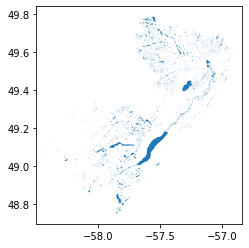

In [67]:
# same as segment, water body data from open canada needs to be 2d

def ddd_to_dd_poly(g):
    return Polygon([xy[0:2] for xy in list(g.exterior.coords)]) 

wb_df['geometry'] = wb_df.geometry.apply(lambda x: ddd_to_dd_poly(x))
wb_df.plot() 


In [68]:
# columns to keep from waterbody dataframe:
wb_cols = ['waterbody_id'] 
pt_wb_nearept_df = ckdnearesl_poly(pt_df, wb_df, wb_cols,utm_zone=UTM_ZONE)

<ipython-input-66-94e7e63047a9>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


In [69]:
pt_wb_nearept_df.sort_values('dist-meters')

,Unnamed: 0,CrossingId,Group,Number,StructureType,CrossingName,Date,RoadName,Latitude,Longitude,...,DFO Comments,Obstruction?,Sent_to_Reg_Review,Monitoring & Occurences Unit Update,Added to pick list?,Issue,Action Required,geometry,waterbody_id,dist-meters
219,220,Humber Arm38,Humber Arm,38,Culvert,Wigwam Brook 003,2019-10-11,Riverside Road,49.452166,-56.975983,...,1% slope and culvert is showing signs of failure.,Maybe,NaN,NaN,NO,NaN,NaN,POINT (-56.97598 49.45217),02YL000-7722,5.724857
217,218,Humber Arm36,Humber Arm,36,Culvert,Gale's Brook 001,2019-10-10,Highway 420,49.547430,-56.998490,...,NaN,No,NaN,NaN,NO,NaN,NaN,POINT (-56.99849 49.54743),02YL000-7776,7.336529
202,203,Humber Arm21,Humber Arm,21,Culvert,West Rocky Brook 003,2019-09-23,JTB 2016 Trail (NLSF),49.252590,-57.527010,...,Beaver dam upstream and beaver activity in cul...,Maybe,NaN,NaN,NO,NaN,NaN,POINT (-57.52701 49.25259),02YL000-7983,24.640313
228,229,Humber Arm47,Humber Arm,47,Culvert,Snooks Brook 001,2019-10-21,Snooks Pond Road,48.944266,-58.105988,...,Slope >1.5% could lead to velocity barrier and...,Yes,2020-07-13,NaN,NO,NaN,NaN,POINT (-58.10599 48.94427),02YL000-7728,33.683331
211,212,Humber Arm30,Humber Arm,30,Culvert,South Brook 007,2019-09-24,North Harbour Road,48.916520,-57.625610,...,2.2% slope and partial obstructions,Yes,2020-07-13,NaN,NO,NaN,NaN,POINT (-57.62561 48.91652),02YL000-7465,112.743854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,423,NCC12,NCC,12,Culvert,CJ-C8 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.496789,-57.068778,...,Backwatered but beaver debris inside could be ...,Maybe,NaN,NaN,YES,Water too deep to fully assess,Further assessment required (try a safer appro...,POINT (-57.06878 53.49679),02YL000-4530,413906.249982
423,424,NCC13,NCC,13,Culvert,CJ-C9 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.512111,-57.072083,...,BACKWATERED,No,NaN,NaN,NO,NaN,NaN,POINT (-57.07208 53.51211),02YL000-4530,415587.359581
424,425,NCC14,NCC,14,Culvert,CJ-C10 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.532694,-57.067056,...,"0.91% slope, and low water levels. Culvert cou...",Maybe,NaN,NaN,NO,NaN,NaN,POINT (-57.06706 53.53269),02YL000-4530,417896.787665
425,426,NCC15,NCC,15,Culvert,CJ-C11 Tributary of Bill Learning’s Pond,2019-10-09,Cartwright Junction,53.560667,-57.060139,...,Debris at inlet could be a barrier,Maybe,NaN,NaN,NO,NaN,NaN,POINT (-57.06014 53.56067),02YL000-4530,421035.788054


## Save:
- CSV for database import

In [71]:
pt_wb_nearept_df.to_csv('data/ACA_to_waterbodies.csv')